# Comparison trained LSTM models and spatial distribution Time Series

In [1]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

import sklearn.metrics
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

num_layers = 3
hidden_size = 32
region = "germany"
epochs = 20
include_time = True

model_dir="/data2/igarss2020/tune/"
log_dir = "/data2/igarss2020/tune/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_log.csv"


../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#!ls /data2/igarss2020/tune/*.csv
log_dir="/data2/igarss2020/tune/"
csv_files = [f for f in os.listdir(log_dir) if f.endswith('csv')] 

mins = list()
for csv in csv_files:
    pth = os.path.join(log_dir,csv)
    df_=pd.read_csv(pth)
    if "mse" in df_.columns:
        series=df_.sort_values(by="mse",ascending=True).iloc[0]
        series.name=csv
        mins.append(series)
    
df = pd.DataFrame(mins).sort_values(by="mse",ascending=True).iloc[:5]
df
#pd.read_csv("/data2/igarss2020/tune/LSTM_germany_l=1_h=32_log.csv").min()

,Unnamed: 0,epoch,mae,mse,rmse,trainloss,testloss
LSTM_germany_l=1_h=256_lr=0.01_weightdecay=0.0001_log.csv,6.0,6.0,0.564666,0.535158,0.731545,0.097423,0.122912
LSTM_germany_l=1_h=512_lr=0.001_weightdecay=0.0001_log.csv,2.0,2.0,0.572563,0.535590,0.731840,0.081873,0.128292
LSTM_germany_l=1_h=512_lr=0.001_weightdecay=1e-06_log.csv,1.0,1.0,0.568887,0.539811,0.734718,0.137650,0.136522
LSTM_germany_l=3_h=128_lr=0.01_weightdecay=0.0001_log.csv,4.0,4.0,0.571181,0.539837,0.734736,0.117891,0.128394
LSTM_germany_l=2_h=128_lr=0.01_weightdecay=0.0001_log.csv,7.0,7.0,0.570935,0.540861,0.735432,0.086679,0.124983


In [3]:
param = dict()
for kv in df.iloc[0].name.split('_'):
    if "=" in kv:
        k,v=kv.split("=")
        param[k]=v
param["epoch"] = int(df.iloc[0]["epoch"])
param

{'l': '1', 'h': '256', 'lr': '0.01', 'weightdecay': '0.0001', 'epoch': 6}

In [4]:
!ls /data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06*

device = torch.device('cuda')

model = Model(input_size=2,
              hidden_size=int(param["h"]),
              num_layers=int(param["l"]),
              output_size=1,
              device=device,
              use_attention=True)

optimizer = torch.optim.Adam(model.parameters(), lr=float(param["lr"]), weight_decay=float(param["weightdecay"]))

model_name = f"LSTM_germany_l={param['l']}_h={param['h']}_lr={param['lr']}_weightdecay={param['weightdecay']}_e={param['epoch']}.pth"

restore("/data2/igarss2020/tune/"+model_name,model, optimizer)

print("/data2/igarss2020/tune/"+model_name)
testdataset = ModisDataset(region=region,
                       fold="test",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,None))

'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=0.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=1.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=2.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=3.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=4.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=5.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=6.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=7.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=8.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=9.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_log.csv'
restoring model from /data2/igarss2020/tune/LSTM_germany_l=1_h=256_lr=0.01_weightdecay=0.0001_e=6.

In [5]:
idx = 79

def plot_example(idx, inner_steps=0):

    N_seen_points = 227#455
    N_predictions = 10

    x = testdataset.data[idx].astype(float)

    finetuned_model = deepcopy(model)
    optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-2, weight_decay=1e-6)

    finetuned_model = fine_tune(x[:N_seen_points], finetuned_model, criterion, optimizer, inner_steps, device=device)

    finetuned_model.train()

    date = testdataset.date[idx].astype(np.datetime64)

    store=None#"/home/marc/projects/igarss2020_tex/img/canada/canada"
    #store=None

    make_and_plot_predictions(finetuned_model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                                  device=device,meanstd=(testdataset.mean,testdataset.std), store=store)


In [6]:
def make_predictions(model, x, date, N_seen_points=250, N_predictions=50, ylim=None, device=torch.device('cpu'), store=None, meanstd=None):

    future = x.shape[0] - N_seen_points

    x_ = torch.Tensor(x)[None, :].to(device)
    if x_.shape[2] == 2:
        doy_seen = x_[:, :N_seen_points, 1]
        doy_future = x_[:, N_seen_points:, 1]
    else:
        doy_seen = None
        doy_future=None
    x_data = x_[:, :N_seen_points, 0].unsqueeze(2)

    mean, epi_var, ale_var,y_hat = model.predict(x_data, N_predictions, future, date=doy_seen, date_future=doy_future, return_yhat=True)
    var = epi_var + ale_var

    mean = mean.cpu().squeeze()
    var = var.cpu().squeeze()
    epi_var = epi_var.cpu().squeeze()
    ale_var = ale_var.cpu().squeeze()

    epi_std = torch.sqrt(epi_var[1:])
    ale_std = torch.sqrt(ale_var[1:])
    data_std = epi_std + ale_std

    if meanstd is not None:
        dmean, dstd = meanstd
        x = (x * dstd) + dmean
        mean = (mean * dstd) + dmean
        y_hat = (y_hat * dstd) + dmean
        ale_std = ale_std * dstd
        epi_std = epi_std * dstd
        data_std = data_std * dstd
    return mean

def calc_dtw(true,pred):
    distances = list()
    for idx in range(true.shape[0]):
        dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
        distances.append(dtw)
    return np.array(distances).mean()

def calc_metrics(true, pred):
    mae = sklearn.metrics.mean_absolute_error(true,pred)
    mse = sklearn.metrics.mean_squared_error(true,pred)
    r2 = sklearn.metrics.r2_score(true,pred)
    return mae, mse, r2

from tqdm.notebook import tqdm

def predict_finetuned(model, x, date, N_predictions, N_seen_points, lr, weight_decay, inner_steps):

    finetuned_model = deepcopy(model)
    optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=lr, weight_decay=weight_decay)

    finetuned_model = fine_tune(x[:N_seen_points], finetuned_model, 
                                criterion, optimizer, inner_steps=inner_steps,device=device)
    #finetuned_model = model
    pred = make_predictions(finetuned_model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                                  device=device,meanstd=(dataset.mean,dataset.std), store=None)

    dstd = dataset.std
    dmean = dataset.mean

    pred = pred[N_seen_points:].cpu().numpy()
    true = x[N_seen_points:,0]
    true = (true * dstd) + dmean

    true = true * 1e-4
    pred = pred * 1e-4
    return true, pred


In [7]:

dataset = testdataset

inner_steps = 1
lr = 1e-3
weight_decay=1e-6
N_predictions = 2

N_data = dataset.data.shape[0]
true = list()
pred = list() 
#N_data = 10
pbar = tqdm(range(N_data), total=N_data)
for idx in pbar:

    N_seen_points = np.where(dataset.date[idx].astype(str) == "2010-01-01")[0][0]
    x = dataset.data[idx].astype(float)
    date = testdataset.date[idx].astype(np.datetime64)

    true_, pred_ = predict_finetuned(model, x, date, N_predictions, N_seen_points, lr, weight_decay, inner_steps)
    true.append(true_)
    pred.append(pred_)
    
    mae, mse, r2 = calc_metrics(np.stack(true).reshape(-1), np.stack(pred).reshape(-1))
    pbar.set_description(f"MAE {mae:.6f}, MSE {mse:.6f}, R2 {r2:.6f}")

true = np.stack(true)
pred = np.stack(pred)

mae, mse, r2 = calc_metrics(np.stack(true).reshape(-1), np.stack(pred).reshape(-1))
print(f"MAE {mae:.6f}, MSE {mse:.6f}, R2 {r2:.6f}")


MAE 0.164940, MSE 0.039065, R2 0.266394


In [13]:
metrics = list()
for idx in tqdm(range(200)):
    mae, mse, r2 = calc_metrics(true[idx], pred[idx])
    dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
    metrics.append([idx,mae,mse,r2,dtw])
    #print(f"idx {idx}, MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}, DTW {dtw:.4f}")
results = pd.DataFrame(metrics,columns=["idx","mae","mse","r2","dtw"]).set_index('idx')

In [14]:
results.std()

mae    0.034688
mse    0.012233
r2     0.347018
dtw    8.789470
dtype: float64

25


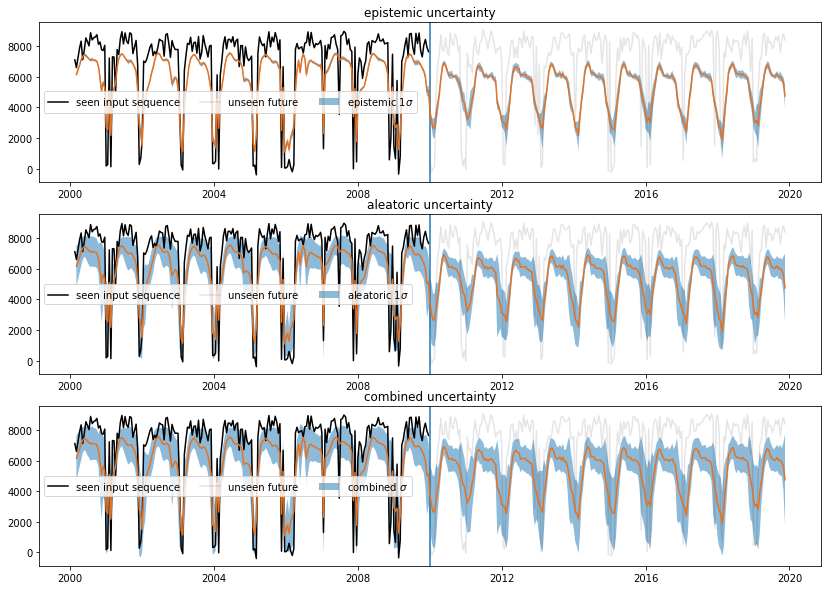

In [15]:
worst = results.sort_values(by="mse").iloc[-1].name
print(worst)
plot_example(worst,inner_steps=0)

159


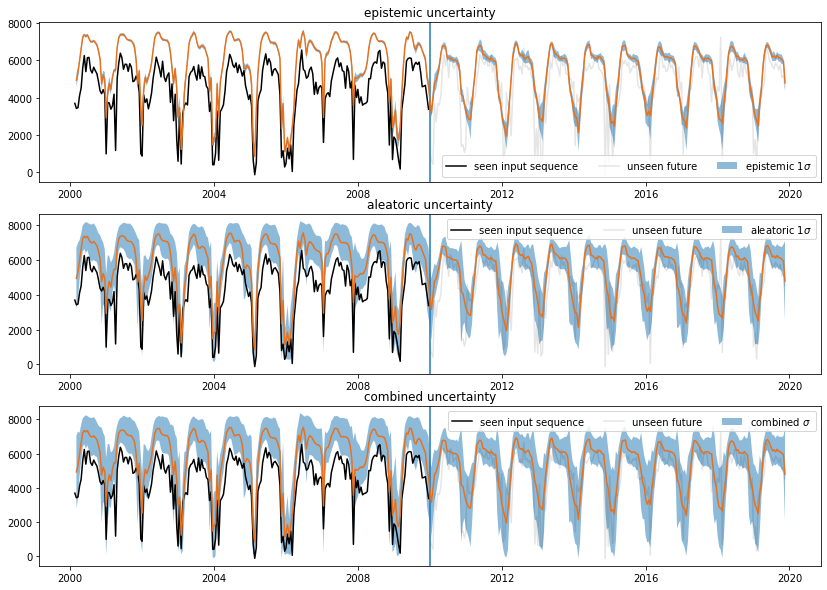

In [16]:
best = results.sort_values(by="mse").iloc[0].name
print(best)
plot_example(best,inner_steps=0)

/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


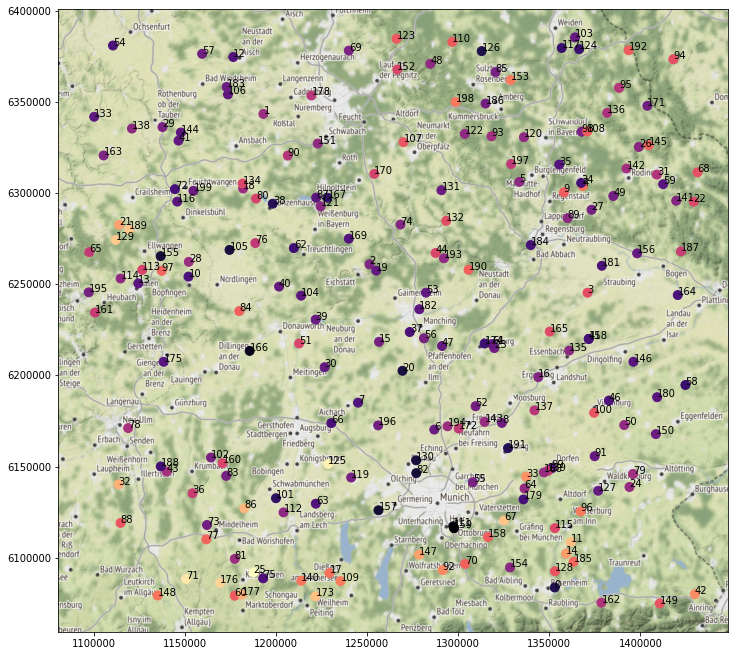

In [17]:
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(dataset.meta, geometry=gpd.points_from_xy(dataset.meta.x, dataset.meta.y),crs=4326).to_crs(epsg=3857)
gdf = pd.concat([gdf.reset_index(),results.reset_index()],axis=1)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

    
fig,ax = plt.subplots(figsize=(12,12))
#gdf.plot(column="mse",ax=ax)
ax.scatter(gdf.geometry.x,gdf.geometry.y,c=gdf.mse,s=80, cmap="magma")

for idx, row in gdf.iterrows():
    ax.annotate(s=f"{row.idx}", xy=(row.geometry.x,row.geometry.y))

url = "http://a.tile.stamen.com/terrain/tileZ/tileX/tileY.png"
add_basemap(ax,9,url)

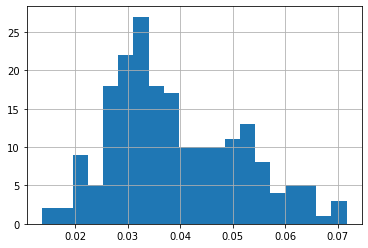

In [18]:
results.mse.hist(bins=20)